In [145]:
!source activate python3
!pip3 install xgboost
!source deactivate

You should consider upgrading via the 'pip install --upgrade pip' command.


In [146]:
import nltk
nltk.download(['punkt', 'stopwords'])

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [147]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [148]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [149]:
feed_hashtag = pd.read_csv(os.getcwd() + '/Datasets/feed_hashtag_long.csv')
feed_hashtag['createdAt'] = pd.to_datetime(feed_hashtag['createdAt'])
print(feed_hashtag.shape)
feed_hashtag.head(1)

(13535, 15)


,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary
0,5eaa8499d9e8980022200604,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,5df3940fb2694d0016bdb721,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30,4,2020,2020-4,5df3940fb2694d0016bdb721,5df38de0b2694d0016bdb71f,starting-out,True,True


In [150]:
feed_hashtag = feed_hashtag[feed_hashtag['isPrimary'] == True]
feed_hashtag = feed_hashtag[~feed_hashtag['text'].isna()]
print("Data Size:", feed_hashtag.shape[0])
print("Unique Content:", feed_hashtag['contentId'].nunique())
print("Unique tags:", feed_hashtag['hashtag'].nunique())

Data Size: 4142
Unique Content: 2523
Unique tags: 11


In [151]:
feed_hashtag['createDate'] = feed_hashtag['createdAt'].dt.date
feed_hashtag.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate
0,5eaa8499d9e8980022200604,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,5df3940fb2694d0016bdb721,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30,4,2020,2020-4,5df3940fb2694d0016bdb721,5df38de0b2694d0016bdb71f,starting-out,True,True,2020-04-30


In [152]:
feed_hashtag.groupby(['createDate']).agg({'contentId':'nunique', 'tagIds':'count'}).head()

,contentId,tagIds
createDate,,
2019-12-12,261,262
2019-12-14,125,133
2019-12-15,2,2
2019-12-16,15,24
2019-12-17,4,8


In [153]:
feed_hashtag = feed_hashtag.sort_values(['contentId'])

In [154]:
feed_hashtag.groupby(['contentId'])['hashtag'].count().reset_index().sort_values(['hashtag'], ascending = False).head()

,contentId,hashtag
1923,5ea903a51081fc002f901eaf,5
2435,5ebe2fa99acd57002817fefe,4
2403,5ebd02339acd57002817faf5,4
2212,5eb697fcbb6731002ababcac,4
2278,5eb95da7be2b9900460549e1,4


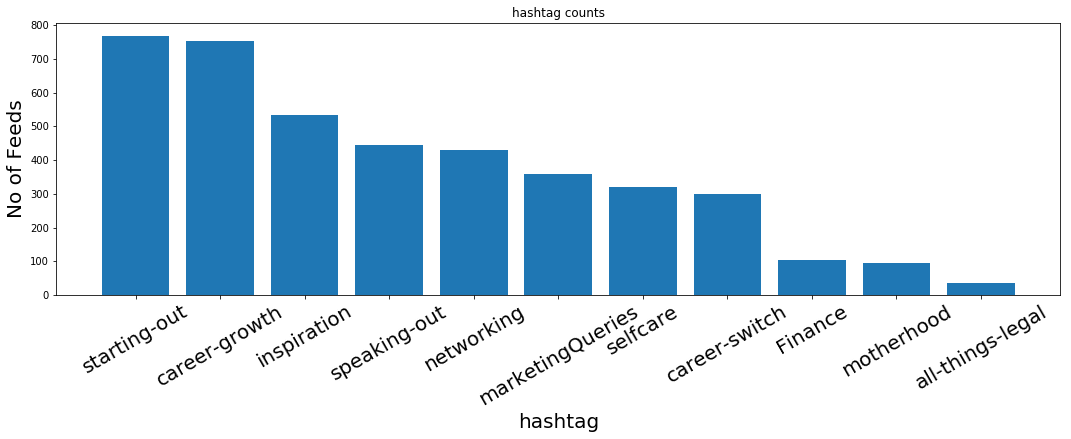

In [155]:
hashtag_class_ct = feed_hashtag.groupby(['hashtag'])['contentId'].agg([('row_count','count'), ('content_count','nunique')]).reset_index()
hashtag_class_ct = hashtag_class_ct.sort_values(['content_count'], ascending=False)
hashtag_class_ct
f, ax = plt.subplots(figsize=(18,5))
plt.bar(hashtag_class_ct['hashtag'], hashtag_class_ct['content_count'])
plt.xlabel('hashtag', fontsize=20)
plt.ylabel('No of Feeds', fontsize=20)
plt.xticks(hashtag_class_ct['hashtag'], fontsize=20, rotation=30)
plt.title('hashtag counts')
plt.show()

In [156]:
feed_hashtag_rollup = feed_hashtag.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(feed_hashtag_rollup.shape)
feed_hashtag_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(2523, 9)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,hashtag_count,hashtag_list
1923,5ea903a51081fc002f901eaf,5ea90095cc13d50046a192fe,2020-04-29 04:33:41.016,"Hi, I am teaching spanish language, If anyone ...",POST,True,True,5,"career-switch,inspiration,selfcare,starting-ou..."
2435,5ebe2fa99acd57002817fefe,5df76af011788b0016813414,2020-05-15 05:59:05.035,We are all fearing the future in some way or t...,QUESTION,True,True,4,"speaking-out,inspiration,selfcare,starting-out"


In [157]:
train = feed_hashtag[feed_hashtag['createdAt'] <= pd.to_datetime('2020-05-04')].copy()
print("train data:", train.shape[0])
test = feed_hashtag[feed_hashtag['createdAt'] > pd.to_datetime('2020-05-04')].copy()
print("test data:", test.shape[0])

train data: 3302
test data: 840


In [158]:
#train = feed_hashtag[~((feed_hashtag['createdAt'] >= pd.to_datetime('2020-04-01')) & (feed_hashtag['createdAt'] < pd.to_datetime('2020-04-16')))].copy()
#print("train data:", train.shape[0])
#test = feed_hashtag[((feed_hashtag['createdAt'] >= pd.to_datetime('2020-04-01')) & (feed_hashtag['createdAt'] < pd.to_datetime('2020-04-16')))].copy()
#print("test data:", test.shape[0])

In [159]:
840/(3302+840)

0.20280057943022695

# Text Cleansing

In [160]:
def del_stop(sent, stop_word_list):
    return [term for term in sent if term not in stop_word_list]

porter = PorterStemmer()
def stem_tokens(token_list):
    token_stem = [porter.stem(term) for term in token_list]
    return(token_stem)

def get_clean_text(txt):
    feed_token = [word_tokenize(sent.lower()) for sent in txt]
    
    stop_punct = list(punctuation)
    stop_nltk = stopwords.words("english")
    stop_updated = stop_nltk + stop_punct
    
    feed_token_clean = [del_stop(sent, stop_updated) for sent in feed_token]
    feed_token_stemmed = [stem_tokens(tk) for tk in feed_token_clean]
    
    clean_text = [" ".join(sent) for sent in feed_token_clean]
    return(clean_text)

In [161]:
train['text_clean'] = get_clean_text(train.text)
train.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
2272,5df454f37e4ea600161b8e2e,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,5df39412b2694d0016bdb72b,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2019-12-14,12,2019,2019-12,5df39412b2694d0016bdb72b,5df38de0b2694d0016bdb71f,career-growth,True,True,2019-12-14,hi shreshtha baking last 5 years brand associa...


In [162]:
test['text_clean'] = get_clean_text(test.text)
test.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
510,5eaf752c1a49d7002e9b0ab0,5e78539bea7e4400225159b8,2020-05-04 01:51:40.441,5df39410b2694d0016bdb724,Homemade Protein hairpack #banana #oils #eggw...,POST,2020-05-04,5,2020,2020-5,5df39410b2694d0016bdb724,5df38de0b2694d0016bdb71f,inspiration,True,True,2020-05-04,homemade protein hairpack banana oils eggwhite...


In [163]:
train_df, validation = model_selection.train_test_split(train, test_size=0.20)
print(train_df.shape)
print(validation.shape)

(2641, 17)
(661, 17)


In [164]:
validation_rollup = validation.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(validation_rollup.shape)
validation_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(601, 10)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,text_clean,hashtag_count,hashtag_list
348,5e8f1f87377db8004c36083f,5e8aa5475fe5e0002204fd81,2020-04-09 13:13:43.305,Heloooo ladies!! First of all thank you for sh...,POST,True,True,heloooo ladies first thank showing interest pl...,3,"inspiration,starting-out,speaking-out"
248,5e82295fcc25880022bcd0e2,5e821e4a12150300454b4dea,2020-03-30 17:16:15.231,"Hiii, I am Subhasree. I recently join this web...",POST,True,True,hiii subhasree recently join website hobby pho...,3,"speaking-out,career-growth,career-switch"


In [165]:
test_rollup = test.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(test_rollup.shape)
test_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(481, 10)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,text_clean,hashtag_count,hashtag_list
152,5eb5cacdb17ccd0028030833,5e809291b0854d0031972a19,2020-05-08 21:10:37.578,"Follow, share and like posts on my Instagram h...",POST,True,True,follow share like posts instagram handle calli...,4,"networking,starting-out,inspiration,speaking-out"
413,5ebec1191ec2470022c91e9d,5ebea81a1ec2470022c91e6a,2020-05-15 16:19:37.425,Hi i am nazima Am a freelance artist.. i make...,POST,True,True,hi nazima freelance artist.. make canvas paint...,4,"inspiration,marketingQueries,networking,career..."


In [166]:
train_x = train_df['text_clean']
train_y = train_df['hashtag']
valid_x = validation_rollup['text_clean']
valid_y = validation_rollup['hashtag_list']
test_x = test_rollup['text_clean']
test_y = test_rollup['hashtag_list']

In [167]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_enc = encoder.fit_transform(train_y)

In [168]:
mapping = pd.DataFrame({'hashtag':train_y, 'hashtag_encoding':train_y_enc})
mapping = mapping.drop_duplicates()
mapping.sort_values(['hashtag_encoding'])

,hashtag,hashtag_encoding
12831,Finance,0
10229,all-things-legal,1
10328,career-growth,2
10083,career-switch,3
10245,inspiration,4
11999,marketingQueries,5
6005,motherhood,6
11718,networking,7
5876,selfcare,8
12790,speaking-out,9


In [169]:
2641+599

3240

# Feature Creation

In [170]:
text_for_feature = train['text_clean']

In [171]:
def feature_creation_func(feature_type):
    if(feature_type == 'Count Vectorizer'):
        # create a count vectorizer object 
        count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
        count_vect.fit(text_for_feature)
        # transform the training and validation data using count vectorizer object
        xtrain_feature =  count_vect.transform(train_x)
        xvalid_feature =  count_vect.transform(valid_x)
        xtest_feature = count_vect.transform(test_x)
    
    if(feature_type == 'Word TFIDF'):
        # word level tf-idf
        tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
        tfidf_vect.fit(text_for_feature)
        xtrain_feature =  tfidf_vect.transform(train_x)
        xvalid_feature =  tfidf_vect.transform(valid_x)
        xtest_feature = tfidf_vect.transform(test_x)
        
    if(feature_type == 'N-gram TFIDF'):
        # ngram level tf-idf 
        tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        tfidf_vect_ngram.fit(text_for_feature)
        xtrain_feature =  tfidf_vect_ngram.transform(train_x)
        xvalid_feature =  tfidf_vect_ngram.transform(valid_x)
        xtest_feature =  tfidf_vect_ngram.transform(test_x)
        
    if(feature_type == 'Character TFIDF'):
        # characters level tf-idf
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        tfidf_vect_ngram_chars.fit(text_for_feature)
        xtrain_feature =  tfidf_vect_ngram_chars.transform(train_x) 
        xvalid_feature =  tfidf_vect_ngram_chars.transform(valid_x) 
        xtest_feature =  tfidf_vect_ngram_chars.transform(test_x)
        
    return(xtrain_feature, xvalid_feature, xtest_feature)

In [ ]:
FEATURE_TYPE = 'Word TFIDF'
xtrain_var, xvalid_var, xtest_var = feature_creation_func(FEATURE_TYPE)

# Model Building

### Shallow Neural Networks

In [172]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(11, activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return(classifier)

In [ ]:
#train_y_onehot_enc = pd.get_dummies(train_y_enc)
#classifier = create_model_architecture(xtrain_var.shape[1])
#classifier.fit(xtrain_var, train_y_onehot_enc, epochs=5)
#prob_predictions = classifier.predict(xvalid_var)

### All Models

In [173]:
def build_model(model_name):
    #Naive Bayes Model
    if(model_name == 'Naive Bayes'):
        model = naive_bayes.MultinomialNB()
        model.fit(xtrain_var, train_y_enc)
    
    #SVM Model
    if(model_name == 'SVM'):
        model = svm.SVC(probability=True)
        model.fit(xtrain_var, train_y_enc)
    
    #Random Forest Model
    if(model_name == 'Random Forest'):
        model = ensemble.RandomForestClassifier()
        model.fit(xtrain_var, train_y_enc)
    
    #XGBoost Model
    if(model_name == 'XGBoost'):
        model = xgboost.XGBClassifier()
        model.fit(xtrain_var, train_y_enc)
    
    #Shallow Neural Networks Model
    if(model_name == 'Shallow Neural Networks'):
        train_y_onehot_enc = pd.get_dummies(train_y_enc)
        
        model = create_model_architecture(xtrain_var.shape[1])
        model.fit(xtrain_var, train_y_onehot_enc, epochs=5)
    
    return(model)

In [ ]:
MODEL_NAME = 'SVM'
classifier = build_model(MODEL_NAME)

### Deep Neural Networks - CNN

In [ ]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((5000,1))

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(input_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(11, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

In [ ]:
classifier = create_cnn()
classifier.fit(xtrain_var, train_y_onehot_enc)

# Prediction for Accuracy

In [174]:
def prediction_accuracy_func(model_name, x_var, measurement_df):
    if(model_name == 'Shallow Neural Networks'):
        prob_predictions = classifier.predict(x_var)
    else:
        prob_predictions = classifier.predict_proba(x_var)
        
    print("Evaluating: ", model_name)
    prob_prediction_df = pd.DataFrame(prob_predictions)
    print("prob_prediction_df", prob_prediction_df.shape)
    prob_prediction_df['contentId'] = measurement_df['contentId']
    
    prob_prediction_df_long = pd.melt(prob_prediction_df, id_vars='contentId', value_vars=range(11))
    prob_prediction_df_long.columns = ['contentId', 'hashtag_encoding', 'predicted_prob']
    prob_prediction_df_long['hashtag_rank'] = prob_prediction_df_long.groupby(['contentId'])['predicted_prob'].rank(ascending=False, method = 'first')
    prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
    prob_prediction_df_long = pd.merge(prob_prediction_df_long, mapping, how = 'left', on = 'hashtag_encoding')
    prob_prediction_df_long['pred_rank'] = 'pred_rank_' + prob_prediction_df_long['hashtag_rank'].astype(int).map(str)
    prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
    print("prob_prediction_df_long", prob_prediction_df_long.shape)
    
    prob_prediction_df_wide = prob_prediction_df_long.pivot_table(index = ['contentId'], columns = 'pred_rank', values = ['hashtag'], aggfunc=lambda x: ''.join(x))
    prob_prediction_df_wide = prob_prediction_df_wide.reset_index()
    prob_prediction_df_wide.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in prob_prediction_df_wide.columns]
    print("prob_prediction_df_wide", prob_prediction_df_wide.shape)
    
    prediction_results = pd.merge(measurement_df[['contentId', 'text', 'hashtag_list', 'hashtag_count']], prob_prediction_df_wide, how = 'right', on='contentId', sort=False, copy=True)
    print("prediction_results", prediction_results.shape)
    
    print("")
    
    print("Exact Match 1st Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_1']))
    print("Exact Match 2nd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_2']))
    print("Exact Match 3rd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_3']))
    print("Exact Match 4th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_4']))
    print("Exact Match 5th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_5']))
    
    h_list = prediction_results['hashtag_list'].str.split(',')

    top_3_pred = prediction_results[['hashtag_pred_rank_1', 'hashtag_pred_rank_2', 'hashtag_pred_rank_3']].values.tolist()
    
    prediction_results['matching_hashtag_ct'] = [len(set(a) & set(b)) for a,b in zip(h_list, top_3_pred)]
    prediction_results['matching_percent'] = (prediction_results['matching_hashtag_ct']/prediction_results['hashtag_count'])*100
    
    pred_summary = prediction_results.groupby(['matching_percent'])['contentId'].count().reset_index()
    pred_summary['content_proportion'] = (pred_summary['contentId']/sum(pred_summary['contentId']))*100
    pred_summary.sort_values(['matching_percent'], ascending=False)
    
    pred_summary_by_hash_ct = prediction_results.groupby(['matching_percent', 'hashtag_count'])['contentId'].count().reset_index()
    pred_summary_by_hash_ct.sort_values(['hashtag_count', 'matching_percent'], ascending=False)
    
    return(pred_summary, pred_summary_by_hash_ct, prediction_results)


In [ ]:
pred_summary_valid, pred_summary_by_hash_ct_valid, prediction_results_valid = prediction_accuracy_func(MODEL_NAME, xvalid_var, validation_rollup)
pred_summary_valid

In [ ]:
pred_summary_by_hash_ct_valid

In [ ]:
prediction_results_valid.head()

In [ ]:
pred_summary_test, pred_summary_by_hash_ct_test, prediction_results_test = prediction_accuracy_func(MODEL_NAME, xtest_var, test_rollup)
pred_summary_test

In [ ]:
pred_summary_by_hash_ct_test

In [ ]:
prediction_results_test[prediction_results_test['matching_percent'] == 75.000000]

# Running All Combinations

In [175]:
feature_list = ['Count Vectorizer', 'Word TFIDF', 'N-gram TFIDF', 'Character TFIDF']
model_list = ['Naive Bayes', 'SVM', 'Random Forest', 'XGBoost', 'Shallow Neural Networks']

In [176]:
summary_valid = pd.DataFrame(columns = ['feature_type', 'model_type', 'match_ct', 'non_match_ct', 'match_proportion', 'non_match_proportion'])
summary_test = pd.DataFrame(columns = ['feature_type', 'model_type', 'match_ct', 'non_match_ct', 'match_proportion', 'non_match_proportion'])
for feature in feature_list:
    FEATURE_TYPE = feature
    xtrain_var, xvalid_var, xtest_var = feature_creation_func(FEATURE_TYPE)
    
    for mod_type in model_list:
        print("==========================================================================================>")
        print("Running ", mod_type, "on ", feature)
                
        MODEL_NAME = mod_type
        classifier = build_model(MODEL_NAME)
        
        #Measuring Validation Data Accuracy
        pred_summary_valid, pred_summary_by_hash_ct_valid, prediction_results_valid = prediction_accuracy_func(MODEL_NAME, xvalid_var, validation_rollup)
        
        pred_summary = pd.DataFrame(index=[0], columns = summary_valid.columns)
        pred_summary['feature_type'] = feature
        pred_summary['model_type'] = mod_type
        pred_summary['match_ct'] = pred_summary_valid[pred_summary_valid['matching_percent']>0.000000]['contentId'].sum()
        pred_summary['non_match_ct'] = pred_summary_valid[pred_summary_valid['matching_percent']==0.000000]['contentId'].sum()
        pred_summary['match_proportion'] = pred_summary_valid[pred_summary_valid['matching_percent']>0.000000]['content_proportion'].sum()
        pred_summary['non_match_proportion'] = pred_summary_valid[pred_summary_valid['matching_percent']==0.000000]['content_proportion'].sum()
        
        summary_valid = summary_valid.append(pred_summary)
        del(pred_summary)
        
        #Measuring Test Data Accuracy
        pred_summary_test, pred_summary_by_hash_ct_test, prediction_results_test = prediction_accuracy_func(MODEL_NAME, xtest_var, test_rollup)
        
        pred_summary = pd.DataFrame(index=[0], columns = summary_test.columns)
        pred_summary['feature_type'] = feature
        pred_summary['model_type'] = mod_type
        pred_summary['match_ct'] = pred_summary_test[pred_summary_test['matching_percent']>0.000000]['contentId'].sum()
        pred_summary['non_match_ct'] = pred_summary_test[pred_summary_test['matching_percent']==0.000000]['contentId'].sum()
        pred_summary['match_proportion'] = pred_summary_test[pred_summary_test['matching_percent']>0.000000]['content_proportion'].sum()
        pred_summary['non_match_proportion'] = pred_summary_test[pred_summary_test['matching_percent']==0.000000]['content_proportion'].sum()
        
        summary_test = summary_test.append(pred_summary)
        

==========================================================================================>
Running  Naive Bayes on  Count Vectorizer
Evaluating:  Naive Bayes
prob_prediction_df (601, 11)
prob_prediction_df_long (6611, 6)
prob_prediction_df_wide (601, 12)
prediction_results (601, 15)

Exact Match 1st Prediction: 103
Exact Match 2nd Prediction: 101
Exact Match 3rd Prediction: 103
Exact Match 4th Prediction: 79
Exact Match 5th Prediction: 46
Evaluating:  Naive Bayes
prob_prediction_df (481, 11)
prob_prediction_df_long (5291, 6)
prob_prediction_df_wide (481, 12)
prediction_results (481, 15)

Exact Match 1st Prediction: 88
Exact Match 2nd Prediction: 73
Exact Match 3rd Prediction: 30
Exact Match 4th Prediction: 24
Exact Match 5th Prediction: 18
==========================================================================================>
Running  SVM on  Count Vectorizer
Evaluating:  SVM
prob_prediction_df (601, 11)
prob_prediction_df_long (6611, 6)
prob_prediction_df_wide (601, 12)
predictio

==========================================================================================>
Running  Naive Bayes on  N-gram TFIDF
Evaluating:  Naive Bayes
prob_prediction_df (601, 11)
prob_prediction_df_long (6611, 6)
prob_prediction_df_wide (601, 12)
prediction_results (601, 15)

Exact Match 1st Prediction: 94
Exact Match 2nd Prediction: 95
Exact Match 3rd Prediction: 86
Exact Match 4th Prediction: 66
Exact Match 5th Prediction: 48
Evaluating:  Naive Bayes
prob_prediction_df (481, 11)
prob_prediction_df_long (5291, 6)
prob_prediction_df_wide (481, 12)
prediction_results (481, 15)

Exact Match 1st Prediction: 85
Exact Match 2nd Prediction: 77
Exact Match 3rd Prediction: 23
Exact Match 4th Prediction: 26
Exact Match 5th Prediction: 19
==========================================================================================>
Running  SVM on  N-gram TFIDF
Evaluating:  SVM
prob_prediction_df (601, 11)
prob_prediction_df_long (6611, 6)
prob_prediction_df_wide (601, 12)
prediction_results (

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


==========================================================================================>
Running  Naive Bayes on  Character TFIDF
Evaluating:  Naive Bayes
prob_prediction_df (601, 11)
prob_prediction_df_long (6611, 6)
prob_prediction_df_wide (601, 12)
prediction_results (601, 15)

Exact Match 1st Prediction: 120
Exact Match 2nd Prediction: 91
Exact Match 3rd Prediction: 83
Exact Match 4th Prediction: 67
Exact Match 5th Prediction: 51
Evaluating:  Naive Bayes
prob_prediction_df (481, 11)
prob_prediction_df_long (5291, 6)
prob_prediction_df_wide (481, 12)
prediction_results (481, 15)

Exact Match 1st Prediction: 98
Exact Match 2nd Prediction: 59
Exact Match 3rd Prediction: 27
Exact Match 4th Prediction: 32
Exact Match 5th Prediction: 13
==========================================================================================>
Running  SVM on  Character TFIDF
Evaluating:  SVM
prob_prediction_df (601, 11)
prob_prediction_df_long (6611, 6)
prob_prediction_df_wide (601, 12)
prediction_re

In [177]:
match_proportion_valid = summary_valid.pivot(index='model_type', columns='feature_type', values = 'match_proportion')
match_proportion_valid = match_proportion_valid[['Count Vectorizer', 'Word TFIDF', 'N-gram TFIDF', 'Character TFIDF']]
match_proportion_valid.head(10)

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,59.234609,57.737105,53.743760,57.404326
Random Forest,57.237937,57.071547,50.748752,57.737105
SVM,62.562396,63.727121,55.407654,64.059900
Shallow Neural Networks,61.730449,61.730449,53.910150,59.900166
XGBoost,58.402662,57.071547,49.084859,55.241265


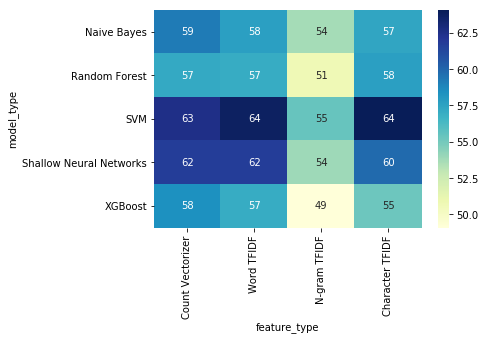

In [178]:
sns.heatmap(match_proportion_valid, annot=True, cmap="YlGnBu")

In [179]:
match_proportion_valid.style.background_gradient(cmap='Blues')

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,59.2346,57.7371,53.7438,57.4043
Random Forest,57.2379,57.0715,50.7488,57.7371
SVM,62.5624,63.7271,55.4077,64.0599
Shallow Neural Networks,61.7304,61.7304,53.9101,59.9002
XGBoost,58.4027,57.0715,49.0849,55.2413


In [180]:
match_proportion_test = summary_test.pivot(index='model_type', columns='feature_type', values = 'match_proportion')
match_proportion_test = match_proportion_test[['Count Vectorizer', 'Word TFIDF', 'N-gram TFIDF', 'Character TFIDF']]
match_proportion_test.head(10)

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,81.912682,81.288981,78.794179,78.794179
Random Forest,80.665281,80.249480,74.012474,81.081081
SVM,79.833680,80.873181,75.259875,82.120582
Shallow Neural Networks,82.120582,80.457380,75.259875,77.130977
XGBoost,84.823285,80.249480,75.883576,78.586279


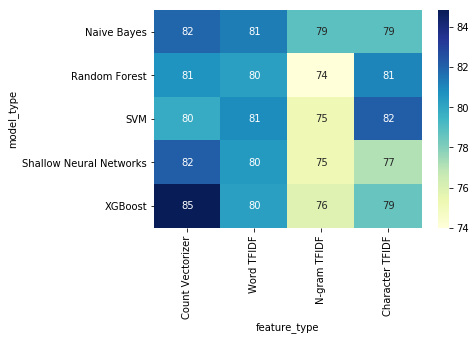

In [181]:
sns.heatmap(match_proportion_test, annot=True, cmap="YlGnBu")

In [182]:
match_proportion_test.style.background_gradient(cmap='Blues')

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,81.9127,81.289,78.7942,78.7942
Random Forest,80.6653,80.2495,74.0125,81.0811
SVM,79.8337,80.8732,75.2599,82.1206
Shallow Neural Networks,82.1206,80.4574,75.2599,77.131
XGBoost,84.8233,80.2495,75.8836,78.5863
